### Table of Contents

* [Introduction](#start)
    * [Questions to answer](#questions)
    * [Import relevant libraries](#import)
    * [Prepare the datasets](#prepare)
        * [User details](#ud-prep)
        * [User score](#us-prep)
        * [Anime dataset](#ad-prep)
    * [Join the dataframes](#join)
* [Analysis](#analysis)
    * [Gender makeup](#gender)
    * [Genres by gender](#gender-genres)
    * [Genres over time](#genres-v-time)
    * [Series similarity](#series-similarity)
* [Conclusion](#conclusion)
    * [What have we learned?](#findings)
    * [Hypothesis](#hypothesis)

## 1 - Introduction <a name="start"></a>

The following data comes from [Anime Dataset 2023](https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset/data?select=users-details-2023.csv) on Kaggle.

We will be looking at three datasets: `users-details-2023.csv`, `users-score-2023.csv`, and `anime-dataset-2023.csv`.

The first dataset, `users-details-2023.csv`, contains information on over 730,000 users registered in MyAnimeList, which is a website designed for users to catalogue and track anime episodes that they have watched or plan to watch. (It is very similar to other social cataloguing websites like Goodreads or Letterboxd; MyAnimeList is just specifically designed for anime enthusiasts.) Details collected about these users in this dataset include their gender, birthdate, location, their account creation date, the number of anime series they have completed, the number they are currently watching, and even the number of total days they have spent watching anime.

The dataset `users-score-2023.csv` contains information on how users rated the various anime series that they've watched. Each individual entry in the dataframe corresponds to a rating given by a single user.

The dataset `anime-dataset-2023.csv` contains information on the anime themselves, including their genre, air dates, and number of episodes.

### Questions to answer <a name="questions"></a>
- What is the gender makeup of the average MyAnimeList user?
- Are certain anime genres more popular among males than females and vice versa?
- How has the nature of anime episodes changed over time? Are certain genres more popular in recent years than in others?
- Within genres, how similar is one anime series to the other? (Based on text analysis of plot synposis provided in `anime-dataset-2023.csv`)

### 1.1 Import relevant libraries <a name="import"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

In [2]:
# Load datasets
user_details = pd.read_csv('users-details-2023.csv')
anime_df = pd.read_csv('anime-dataset-2023.csv')
user_score = pd.read_csv('users-score-2023.csv')

### 1.2 Prepare the datasets <a name="prepare"></a>

Let's look at the datasets and determine whether they need any cleaning.

Additionally, since we are interested in the popularity of certain anime genres among males versus females, we will need to join the `user_details` and `user_score` dataframes.

#### User details <a name="ud-prep"></a>

In [3]:
# Look at user_details head
user_details.head()

,Mal ID,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
0,1,Xinil,Male,1985-03-04T00:00:00+00:00,California,2004-11-05T00:00:00+00:00,142.3,7.37,1.0,233.0,8.0,93.0,64.0,399.0,60.0,8458.0
1,3,Aokaado,Male,NaN,"Oslo, Norway",2004-11-11T00:00:00+00:00,68.6,7.34,23.0,137.0,99.0,44.0,40.0,343.0,15.0,4072.0
2,4,Crystal,Female,NaN,"Melbourne, Australia",2004-11-13T00:00:00+00:00,212.8,6.68,16.0,636.0,303.0,0.0,45.0,1000.0,10.0,12781.0
3,9,Arcane,NaN,NaN,NaN,2004-12-05T00:00:00+00:00,30.0,7.71,5.0,54.0,4.0,3.0,0.0,66.0,0.0,1817.0
4,18,Mad,NaN,NaN,NaN,2005-01-03T00:00:00+00:00,52.0,6.27,1.0,114.0,10.0,5.0,23.0,153.0,42.0,3038.0


In [4]:
user_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731290 entries, 0 to 731289
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Mal ID            731290 non-null  int64  
 1   Username          731289 non-null  object 
 2   Gender            224383 non-null  object 
 3   Birthday          168068 non-null  object 
 4   Location          152805 non-null  object 
 5   Joined            731290 non-null  object 
 6   Days Watched      731282 non-null  float64
 7   Mean Score        731282 non-null  float64
 8   Watching          731282 non-null  float64
 9   Completed         731282 non-null  float64
 10  On Hold           731282 non-null  float64
 11  Dropped           731282 non-null  float64
 12  Plan to Watch     731282 non-null  float64
 13  Total Entries     731282 non-null  float64
 14  Rewatched         731282 non-null  float64
 15  Episodes Watched  731282 non-null  float64
dtypes: float64(10), int6

One thing to note is that the `Location` is not in a tidy format, so we might not be able to extract much useful information based on this feature without extensive cleaning. We will go ahead and drop this column.

We will also dropped the columns `'Watching'`, `'Completed'`, `'On hold'`, `'Dropped'`, and `'Plan to Watch'`.

It might be informative to have each user's age, so let's get `Birthday` into a usable format.

In [5]:
drop_cols = ['Location', 'Watching', 'Completed', 'On Hold', 'Dropped', 'Plan to Watch']
user_details = user_details.drop(columns=drop_cols)

In [6]:
# Convert 'Birthday' to datetime format, invalid dates will be set to NaT
user_details['Birthday'] = pd.to_datetime(user_details['Birthday'], errors='coerce').dt.date

# Calculate the current date
current_date = datetime.now().date()

# Calculate age for valid dates, skip NaT values
user_details['Age'] = user_details['Birthday'].apply(
    lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)) if pd.notnull(x) else None
)

In [7]:
# Check head of dataframe with new age column
user_details.head()

,Mal ID,Username,Gender,Birthday,Joined,Days Watched,Mean Score,Total Entries,Rewatched,Episodes Watched,Age
0,1,Xinil,Male,1985-03-04,2004-11-05T00:00:00+00:00,142.3,7.37,399.0,60.0,8458.0,39.0
1,3,Aokaado,Male,NaT,2004-11-11T00:00:00+00:00,68.6,7.34,343.0,15.0,4072.0,NaN
2,4,Crystal,Female,NaT,2004-11-13T00:00:00+00:00,212.8,6.68,1000.0,10.0,12781.0,NaN
3,9,Arcane,NaN,NaT,2004-12-05T00:00:00+00:00,30.0,7.71,66.0,0.0,1817.0,NaN
4,18,Mad,NaN,NaT,2005-01-03T00:00:00+00:00,52.0,6.27,153.0,42.0,3038.0,NaN


#### User score <a name="us-prep"></a>

In [8]:
user_score.head()

,user_id,Username,anime_id,Anime Title,rating
0,1,Xinil,21,One Piece,9
1,1,Xinil,48,.hack//Sign,7
2,1,Xinil,320,A Kite,5
3,1,Xinil,49,Aa! Megami-sama!,8
4,1,Xinil,304,Aa! Megami-sama! Movie,8


It looks like `user_id` in our `user_score` dataframe corresponds to the `Mal ID` in `user_details`.

#### Anime dataset <a name="ad-prep"></a>

In [9]:
anime_df

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24900,55731,Wu Nao Monu,UNKNOWN,无脑魔女,UNKNOWN,"Comedy, Fantasy, Slice of Life",No description available for this anime.,ONA,15.0,"Jul 4, 2023 to ?",...,UNKNOWN,Web manga,Unknown,PG-13 - Teens 13 or older,UNKNOWN,24723,0,UNKNOWN,0,https://cdn.myanimelist.net/images/anime/1386/...
24901,55732,Bu Xing Si: Yuan Qi,Blader Soul,捕星司·源起,UNKNOWN,"Action, Adventure, Fantasy",No description available for this anime.,ONA,18.0,"Jul 27, 2023 to ?",...,UNKNOWN,Web novel,Unknown,PG-13 - Teens 13 or older,0.0,0,0,UNKNOWN,0,https://cdn.myanimelist.net/images/anime/1383/...
24902,55733,Di Yi Xulie,The First Order,第一序列,UNKNOWN,"Action, Adventure, Fantasy, Sci-Fi",No description available for this anime.,ONA,16.0,"Jul 19, 2023 to ?",...,UNKNOWN,Web novel,Unknown,PG-13 - Teens 13 or older,0.0,0,0,UNKNOWN,0,https://cdn.myanimelist.net/images/anime/1130/...
24903,55734,Bokura no Saishuu Sensou,UNKNOWN,僕らの最終戦争,UNKNOWN,UNKNOWN,A music video for the song Bokura no Saishuu S...,Music,1.0,"Apr 23, 2022",...,UNKNOWN,Original,3 min,PG-13 - Teens 13 or older,0.0,0,0,UNKNOWN,0,https://cdn.myanimelist.net/images/anime/1931/...


Something else to note is that the `anime_id` in `anime_df` corresponds to the `anime_id` in `user_score`.

In [10]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anime_id      24905 non-null  int64 
 1   Name          24905 non-null  object
 2   English name  24905 non-null  object
 3   Other name    24905 non-null  object
 4   Score         24905 non-null  object
 5   Genres        24905 non-null  object
 6   Synopsis      24905 non-null  object
 7   Type          24905 non-null  object
 8   Episodes      24905 non-null  object
 9   Aired         24905 non-null  object
 10  Premiered     24905 non-null  object
 11  Status        24905 non-null  object
 12  Producers     24905 non-null  object
 13  Licensors     24905 non-null  object
 14  Studios       24905 non-null  object
 15  Source        24905 non-null  object
 16  Duration      24905 non-null  object
 17  Rating        24905 non-null  object
 18  Rank          24905 non-null  object
 19  Popu

In [11]:
anime_df.columns

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Genres',
       'Synopsis', 'Type', 'Episodes', 'Aired', 'Premiered', 'Status',
       'Producers', 'Licensors', 'Studios', 'Source', 'Duration', 'Rating',
       'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members', 'Image URL'],
      dtype='object')

In [12]:
anime_df['Rating'].unique()

array(['R - 17+ (violence & profanity)', 'PG-13 - Teens 13 or older',
       'PG - Children', 'R+ - Mild Nudity', 'G - All Ages', 'Rx - Hentai',
       'UNKNOWN'], dtype=object)

Our `anime_df` dataframe needs extensive cleaning:
- We only need the English title of the series, so let's drop `name` and `Other name`.
- Some series have multiple genres, so we will need to separate these.
- We need to get our `Aired` dates into a usable format so that we can analyze how genre development has varied over time. Let's also drop `Premiered`, since it will be redundant after we change the `Aired` date to a usable format.
- Let's drop the `Image URL` column since it is of no use to our data analysis.
- I would like to keep this project friendly to general audiences, so I am going to exclude any anime series with a rating of `'Rx - Hentai'`. Additionally, I will be removing genres that could potentially contain adult content. This would include the following genres: `'Ecchi'`, `'Hentai'`, `'Erotica'`, `'Boys Love'`, and `'Girls Love'`.

##### Drop columns

In [13]:
# Let's create a list of the columns that we would like to drop.
drop_cols = ['Name', 'Other name', 'Premiered', 'Image URL']

# Drop columns
anime_df = anime_df.drop(drop_cols, axis=1)

In [14]:
anime_df.columns

Index(['anime_id', 'English name', 'Score', 'Genres', 'Synopsis', 'Type',
       'Episodes', 'Aired', 'Status', 'Producers', 'Licensors', 'Studios',
       'Source', 'Duration', 'Rating', 'Rank', 'Popularity', 'Favorites',
       'Scored By', 'Members'],
      dtype='object')

##### Format `Aired` dates

In [15]:
def extract_years(aired_str):
    # Split the string by ' to '
    parts = aired_str.split(' to ')
    
    # Define date formats
    formats = ['%b %d, %Y', '%b %Y']  # Include formats for both complete and partial dates

    def try_parsing_date(date_str):
        for fmt in formats:
            try:
                return datetime.strptime(date_str, fmt)
            except ValueError:
                continue
        return None

    if len(parts) == 2:
        start_date, end_date = parts
        start_date = try_parsing_date(start_date)
        end_date = try_parsing_date(end_date) if end_date != '?' else None
    elif len(parts) == 1:
        start_date = try_parsing_date(parts[0])
        end_date = None
    else:
        start_date = end_date = None
    
    # Extract the year from datetime objects
    start_year = start_date.year if start_date else None
    end_year = end_date.year if end_date else None
    
    return start_year, end_year

# Apply the function to the 'Aired' column
anime_df[['Aired_Start_Year', 'Aired_End_Year']] = anime_df['Aired'].apply(lambda x: pd.Series(extract_years(x)))

# Display the updated DataFrame
print(anime_df[['Aired', 'Aired_Start_Year', 'Aired_End_Year']].head())

                          Aired  Aired_Start_Year  Aired_End_Year
0   Apr 3, 1998 to Apr 24, 1999            1998.0          1999.0
1                   Sep 1, 2001            2001.0             NaN
2   Apr 1, 1998 to Sep 30, 1998            1998.0          1998.0
3   Jul 3, 2002 to Dec 25, 2002            2002.0          2002.0
4  Sep 30, 2004 to Sep 29, 2005            2004.0          2005.0


##### Separate genres

In [16]:
# Split the 'Genres' column by commas and create a list of all genres
all_genres = anime_df['Genres'].str.split(', ').explode()
all_genres.unique()

array(['Action', 'Award Winning', 'Sci-Fi', 'Adventure', 'Drama',
       'Mystery', 'Supernatural', 'Fantasy', 'Sports', 'Comedy',
       'Romance', 'Slice of Life', 'Suspense', 'Ecchi', 'Gourmet',
       'Avant Garde', 'Horror', 'Girls Love', 'Boys Love', 'Hentai',
       'UNKNOWN', 'Erotica'], dtype=object)

In [17]:
# Split the 'Genres' column by commas
anime_df['Genres'] = anime_df['Genres'].str.split(', ')

# Use pd.get_dummies with the 'Genres' column
# First, explode the genres so each genre has its own row
anime_genres_exploded = anime_df.explode('Genres')

##### Create dummy variables for categorical variables

In [18]:
# Create dummy variables for the genres
genre_dummies = pd.get_dummies(anime_genres_exploded['Genres'])

In [19]:
# Combine the dummy variables back with the original DataFrame
anime_df_with_dummies = pd.concat([anime_df, genre_dummies], axis=1)

# Drop the original 'Genres' column
anime_df_with_dummies = anime_df_with_dummies.drop(columns=['Genres'])

In [20]:
anime_df_with_dummies.columns

Index(['anime_id', 'English name', 'Score', 'Synopsis', 'Type', 'Episodes',
       'Aired', 'Status', 'Producers', 'Licensors', 'Studios', 'Source',
       'Duration', 'Rating', 'Rank', 'Popularity', 'Favorites', 'Scored By',
       'Members', 'Aired_Start_Year', 'Aired_End_Year', 'Action', 'Adventure',
       'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Ecchi',
       'Erotica', 'Fantasy', 'Girls Love', 'Gourmet', 'Hentai', 'Horror',
       'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports',
       'Supernatural', 'Suspense', 'UNKNOWN'],
      dtype='object')

In [21]:
# Group by 'anime_id' and collapse the dummies dataframe so there is only one entry per anime
anime_df_with_dummies_agg = anime_df_with_dummies.groupby('anime_id').agg({
    'anime_id': 'first',
    'English name': 'first', 
    'Score': 'first',
    'Synopsis': 'first', 
    'Type': 'first', 
    'Episodes': 'first', 
    'Aired': 'first', 
    'Status': 'first',
    'Producers': 'first',
    'Licensors': 'first',
    'Studios': 'first',
    'Source': 'first',
    'Duration': 'first',
    'Rating': 'first',
    'Rank': 'first',
    'Popularity': 'first',
    'Favorites': 'first',
    'Scored By': 'first', 
    'Members': 'first', 
    'Aired_Start_Year': 'first', 
    'Aired_End_Year': 'first',
    **{col: 'sum' for col in genre_dummies.columns}
})

anime_df_with_dummies_agg.head()

,anime_id,English name,Score,Synopsis,Type,Episodes,Aired,Status,Producers,Licensors,...,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense,UNKNOWN
anime_id,,,,,,,,,,,,,,,,,,,,,
1,1,Cowboy Bebop,8.75,"Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",Finished Airing,Bandai Visual,"Funimation, Bandai Entertainment",...,0,0,0,0,1,0,0,0,0,0
5,5,Cowboy Bebop: The Movie,8.38,"Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",Finished Airing,"Sunrise, Bandai Visual",Sony Pictures Entertainment,...,0,0,0,0,1,0,0,0,0,0
6,6,Trigun,8.22,"Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",Finished Airing,Victor Entertainment,"Funimation, Geneon Entertainment USA",...,0,0,0,0,1,0,0,0,0,0
7,7,Witch Hunter Robin,7.25,Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",Finished Airing,"Bandai Visual, Dentsu, Victor Entertainment, T...","Funimation, Bandai Entertainment",...,0,0,1,0,0,0,0,1,0,0
8,8,Beet the Vandel Buster,6.94,It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",Finished Airing,"TV Tokyo, Dentsu",Illumitoon Entertainment,...,0,0,0,0,0,0,0,1,0,0


In [22]:
# Reassign anime_df_with_dummies_agg to anime_df
anime_df = anime_df_with_dummies_agg

##### Remove any adult series

In [23]:
# Define a list of genres considered "adult"
adult_genres = ['Ecchi', 'Hentai', 'Erotica', 'Boys Love', 'Girls Love']

# Create a new dataframe from anime_df that excludes the adult genres
anime_df_clean = anime_df[~anime_df[adult_genres].any(axis=1)].reset_index(drop=True)

In [24]:
anime_df_clean

,anime_id,English name,Score,Synopsis,Type,Episodes,Aired,Status,Producers,Licensors,...,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense,UNKNOWN
0,1,Cowboy Bebop,8.75,"Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",Finished Airing,Bandai Visual,"Funimation, Bandai Entertainment",...,0,0,0,0,1,0,0,0,0,0
1,5,Cowboy Bebop: The Movie,8.38,"Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",Finished Airing,"Sunrise, Bandai Visual",Sony Pictures Entertainment,...,0,0,0,0,1,0,0,0,0,0
2,6,Trigun,8.22,"Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",Finished Airing,Victor Entertainment,"Funimation, Geneon Entertainment USA",...,0,0,0,0,1,0,0,0,0,0
3,7,Witch Hunter Robin,7.25,Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",Finished Airing,"Bandai Visual, Dentsu, Victor Entertainment, T...","Funimation, Bandai Entertainment",...,0,0,1,0,0,0,0,1,0,0
4,8,Beet the Vandel Buster,6.94,It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",Finished Airing,"TV Tokyo, Dentsu",Illumitoon Entertainment,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22362,55731,UNKNOWN,UNKNOWN,No description available for this anime.,ONA,15.0,"Jul 4, 2023 to ?",Not yet aired,UNKNOWN,UNKNOWN,...,0,0,0,0,0,1,0,0,0,0
22363,55732,Blader Soul,UNKNOWN,No description available for this anime.,ONA,18.0,"Jul 27, 2023 to ?",Not yet aired,UNKNOWN,UNKNOWN,...,0,0,0,0,0,0,0,0,0,0
22364,55733,The First Order,UNKNOWN,No description available for this anime.,ONA,16.0,"Jul 19, 2023 to ?",Finished Airing,UNKNOWN,UNKNOWN,...,0,0,0,0,1,0,0,0,0,0
22365,55734,UNKNOWN,UNKNOWN,A music video for the song Bokura no Saishuu S...,Music,1.0,"Apr 23, 2022",Finished Airing,UNKNOWN,UNKNOWN,...,0,0,0,0,0,0,0,0,0,1


Let's drop any entries with a rating of 'Rx - Hentai', just in case any were missed when we dropped the adult genres.

In [25]:
# Drop entries where anime_df_clean['Rating']=='Rx - Hentai'
anime_df_clean = anime_df_clean[anime_df_clean['Rating'] != 'Rating_Rx - Hentai'].reset_index(drop=True)

In [26]:
anime_df_clean.head()

,anime_id,English name,Score,Synopsis,Type,Episodes,Aired,Status,Producers,Licensors,...,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense,UNKNOWN
0,1,Cowboy Bebop,8.75,"Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",Finished Airing,Bandai Visual,"Funimation, Bandai Entertainment",...,0,0,0,0,1,0,0,0,0,0
1,5,Cowboy Bebop: The Movie,8.38,"Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",Finished Airing,"Sunrise, Bandai Visual",Sony Pictures Entertainment,...,0,0,0,0,1,0,0,0,0,0
2,6,Trigun,8.22,"Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",Finished Airing,Victor Entertainment,"Funimation, Geneon Entertainment USA",...,0,0,0,0,1,0,0,0,0,0
3,7,Witch Hunter Robin,7.25,Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",Finished Airing,"Bandai Visual, Dentsu, Victor Entertainment, T...","Funimation, Bandai Entertainment",...,0,0,1,0,0,0,0,1,0,0
4,8,Beet the Vandel Buster,6.94,It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",Finished Airing,"TV Tokyo, Dentsu",Illumitoon Entertainment,...,0,0,0,0,0,0,0,1,0,0


In [27]:
# Reassign anime_df_clean to anime_df
anime_df = anime_df_clean

### 1.3 Join the dataframes <a name="join"></a>
Before performing our analysis, let's join all our dataframes into one large dataframe.

We will start by joining our `user_score` and `anime_df` dataframes on `anime_id`.

First, we will need to make a quick adjustment. Recall that `user_score` still contains scores for the series that we dropped in `anime_df`. Let's make sure we exclude those before we join the two dataframes.

In [28]:
# Create a list of valid anime_ids based on what is in anime_df
valid_anime_ids = anime_df['anime_id'].unique()

In [29]:
# Filter user_score to contain anime_ids that are only in our valid_anime_ids list
user_score = user_score[user_score['anime_id'].isin(valid_anime_ids)]

Now, we are ready to merge `user_score` with `anime_df` on `anime_id`.

In [30]:
merged_df = pd.merge(user_score, anime_df, on='anime_id', how='left')

In [31]:
# Check the dataframe
merged_df.head()

,user_id,Username,anime_id,Anime Title,rating,English name,Score,Synopsis,Type,Episodes,...,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense,UNKNOWN
0,1,Xinil,21,One Piece,9,One Piece,8.69,"Gol D. Roger was known as the ""Pirate King,"" t...",TV,UNKNOWN,...,0,0,0,0,0,0,0,0,0,0
1,1,Xinil,48,.hack//Sign,7,.hack//Sign,6.95,"A young wavemaster, only known by the alias of...",TV,26.0,...,0,0,1,0,0,0,0,0,0,0
2,1,Xinil,49,Aa! Megami-sama!,8,Oh! My Goddess,7.29,When college student Keiichi Morisato dials th...,OVA,5.0,...,0,0,0,1,0,0,0,1,0,0
3,1,Xinil,304,Aa! Megami-sama! Movie,8,Ah! My Goddess: The Movie,7.54,"For centuries, a god named Celestin has been i...",Movie,1.0,...,0,0,0,1,0,0,0,1,0,0
4,1,Xinil,53,Ai Yori Aoshi,7,Ai Yori Aoshi,7.11,"Kaoru Hanabishi, a college student who lives a...",TV,24.0,...,0,0,0,1,0,0,0,0,0,0


Let's merge `merged_df` and `user_details`. Recall how `user_id` is equivalent to `Mal ID` in `user_details`.

Let's make sure to drop `Username` from one of the dataframes since this appears in both dataframes. We will also drop `Mal ID` since this is also equivalent to `user_id` and therefore redundant.

In [32]:
merged_df_details = pd.merge(merged_df, user_details.drop(columns=['Username']), left_on='user_id', 
                             right_on='Mal ID', how='left')

merged_df_details = merged_df_details.drop(columns='Mal ID')

In [33]:
# Check the dataframe
merged_df_details.head()

,user_id,Username,anime_id,Anime Title,rating,English name,Score,Synopsis,Type,Episodes,...,UNKNOWN,Gender,Birthday,Joined,Days Watched,Mean Score,Total Entries,Rewatched,Episodes Watched,Age
0,1,Xinil,21,One Piece,9,One Piece,8.69,"Gol D. Roger was known as the ""Pirate King,"" t...",TV,UNKNOWN,...,0,Male,1985-03-04,2004-11-05T00:00:00+00:00,142.3,7.37,399.0,60.0,8458.0,39.0
1,1,Xinil,48,.hack//Sign,7,.hack//Sign,6.95,"A young wavemaster, only known by the alias of...",TV,26.0,...,0,Male,1985-03-04,2004-11-05T00:00:00+00:00,142.3,7.37,399.0,60.0,8458.0,39.0
2,1,Xinil,49,Aa! Megami-sama!,8,Oh! My Goddess,7.29,When college student Keiichi Morisato dials th...,OVA,5.0,...,0,Male,1985-03-04,2004-11-05T00:00:00+00:00,142.3,7.37,399.0,60.0,8458.0,39.0
3,1,Xinil,304,Aa! Megami-sama! Movie,8,Ah! My Goddess: The Movie,7.54,"For centuries, a god named Celestin has been i...",Movie,1.0,...,0,Male,1985-03-04,2004-11-05T00:00:00+00:00,142.3,7.37,399.0,60.0,8458.0,39.0
4,1,Xinil,53,Ai Yori Aoshi,7,Ai Yori Aoshi,7.11,"Kaoru Hanabishi, a college student who lives a...",TV,24.0,...,0,Male,1985-03-04,2004-11-05T00:00:00+00:00,142.3,7.37,399.0,60.0,8458.0,39.0


In [51]:
# Assign merged_df_details to df for simplicity. Drop columns that belong to adult genres, since these are not needed.
df = merged_df_details.drop(adult_genres, axis=1)

In [52]:
df.columns

Index(['user_id', 'Username', 'anime_id', 'Anime Title', 'rating',
       'English name', 'Score', 'Synopsis', 'Type', 'Episodes', 'Aired',
       'Status', 'Producers', 'Licensors', 'Studios', 'Source', 'Duration',
       'Rating', 'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members',
       'Aired_Start_Year', 'Aired_End_Year', 'Action', 'Adventure',
       'Avant Garde', 'Award Winning', 'Comedy', 'Drama', 'Fantasy', 'Gourmet',
       'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports',
       'Supernatural', 'Suspense', 'UNKNOWN', 'Gender', 'Birthday', 'Joined',
       'Days Watched', 'Mean Score', 'Total Entries', 'Rewatched',
       'Episodes Watched', 'Age'],
      dtype='object')

---

## 2 - Analysis <a name="analysis"></a>

### 2.1 Gender makeup <a name="gender"></a>
Let's answer our first question:
>What is the gender makeup of the average MyAnimeList user?

In [34]:
female_count = user_details[user_details['Gender']=='Female'].shape[0]
male_count = user_details[user_details['Gender']=='Male'].shape[0]
nb_count = user_details[user_details['Gender']=='Non-Binary'].shape[0]
gender_total = user_details['Gender'].count()

In [35]:
print(f"Out of {gender_total} total users who provided a gender in their profile:")
print(f"Percentage female: {female_count/gender_total*100:.2f}%")
print(f"Percentage male: {male_count/gender_total*100:.2f}%")
print(f"Percentage non-binary: {nb_count/gender_total*100:.2f}%")

Out of 224383 total users who provided a gender in their profile:
Percentage female: 43.00%
Percentage male: 56.59%
Percentage non-binary: 0.41%


Perhaps unsurprisingly, the majority of users on MyAnimeList are male.

Here this is represented as a pie chart:

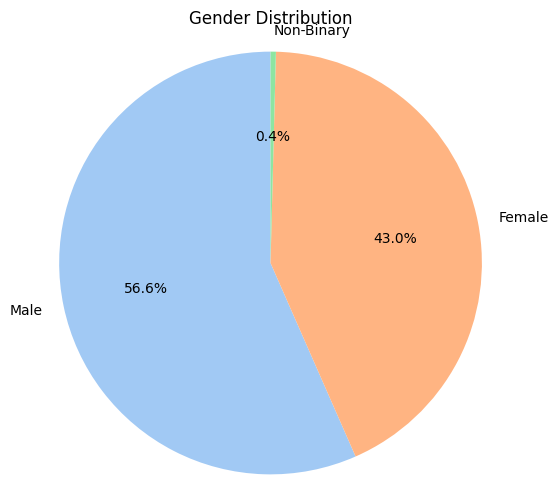

In [36]:
# Count the number of each gender category
gender_counts = user_details['Gender'].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()

Here this is represented as a bar chart:

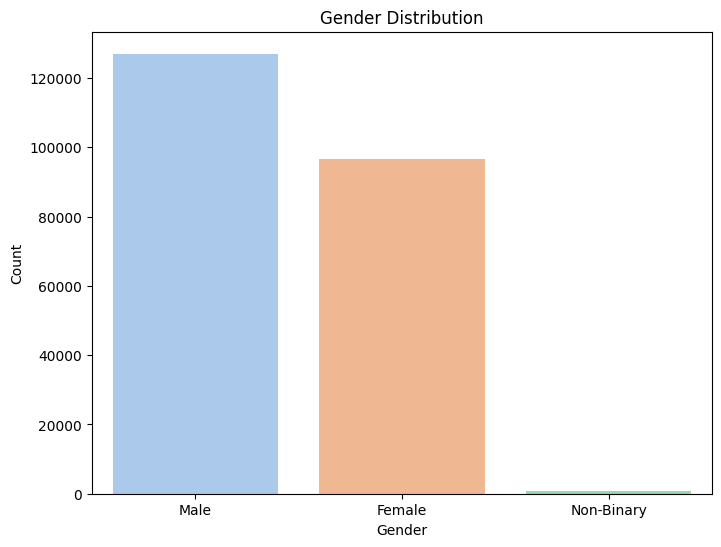

In [37]:
# Plot a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

### 2.2 Genres by gender <a name="gender-genres"></a>

> Are certain anime genres more popular among males than females and vice versa?

In [66]:
df_genres = ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Comedy', 'Drama', 'Fantasy', 'Gourmet',
       'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports',
       'Supernatural', 'Suspense', 'UNKNOWN']

In [68]:
gender_df = df.groupby(['Gender'])[df_genres].aggregate('sum')

In [81]:
melted_df = pd.melt(gender_df.reset_index(), id_vars=['Gender'], var_name='genre', value_name='count')

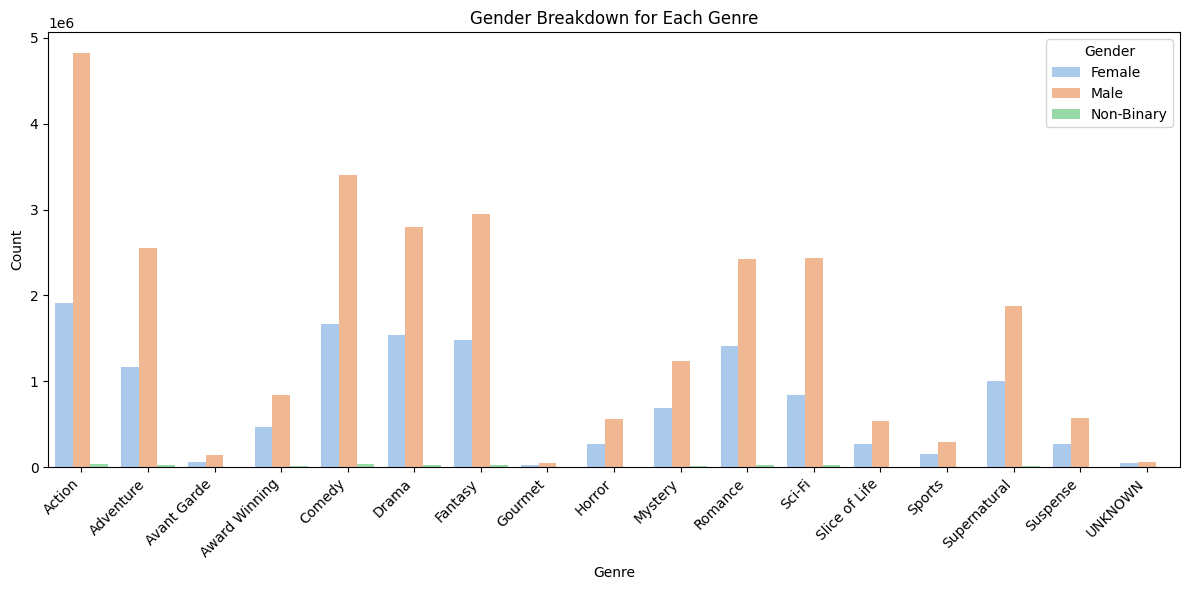

In [86]:
plt.figure(figsize=(12, 6))  # Adjust figure size as necessary
sns.barplot(x='genre', y='count', hue='Gender', data=melted_df, palette='pastel')

# Add title and labels
plt.title('Gender Breakdown for Each Genre')
plt.xlabel('Genre')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

### 2.3 Genres over time <a name="genres-v-time"></a>

```
This is a time series problem. Make a time series plot where each line represents a genre. Maybe exclude anything that is UNKNOWN from this analysis.
```

Let's answer our second question:
> How has the nature of anime episodes changed over time? Are certain genres more popular in recent years than in others?

In [ ]:
for col in anime_df.columns:
    print(f"{col}:")
    print(anime_df[col].unique())
    print("---")

### 2.4 Series similarity <a name="series-similarity"></a>

```
Do cosine similarity on the Synopsis column for each genre
```

> Within genres, how similar is one anime series to the other?

## 3 - Conclusion <a name="conclusion"></a>

### 3.1 What have we learned? <a name="findings"></a>

```
Summarize findings here. Maybe bring in an anecdote or a news report to make it more interesting and add some depth.
```


### 3.2 Hypothesis <a name="hypothesis"></a>

```
A hypothesis is a required part of the rubric, so make sure you include one.
```